# Librairies utiles

In [1]:
from bitarray import bitarray
import mmh3
import datetime
import numpy as np
import scipy.stats
import pandas as pd
import random # Pour générer des nombres aléatoirement pour les fonctions de hachage
import copy
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

# Classe Bloom Filter Modifiée

## Bloom Filter

In [2]:
class BloomFilter(object):
 
    '''
    Class for Bloom filter, using murmur3 hash function
    '''
 
    def __init__(self, max_items, max_fp_prob):
        '''
        max_items : int
            Maximum number of items expected to be stored in bloom filter
        max_fp_prob : float
            False Positive probability threshold in decimal
        '''
        # Size of bit array to use
        self.size = self.get_size(max_items, max_fp_prob)
        
        # Number of hash functions to use
        self.hash_count = self.get_hash_count(self.size, max_items)
        
        # Random seeds of hash functions : permet de ne pas créer à chaque fois le même filtre (rigoureusement).
        self.seeds = random.sample(range(100), self.hash_count)
                
        # False possible probability in decimal
        self.fp_prob = 0 # Initialized to 0 because no items in the filter
 
        # Bit array of given size
        self.bit_array = bitarray(self.size)
        self.bit_array.setall(0) # Initialize all bits as 0
        
        # Number of items currently in the filter : increase by one each time we add an element
        self.unique_items = 0 # Initialized to 0
        
        # Usual (litterature) estimator for counting items : based on number of bits set to one in the filter.
        self.estimate_items = 0 # Initialized to 0
        
        
    def check(self, item):
        '''
        Check for existence of an item in filter
        '''
        for i in self.seeds:
            digest = mmh3.hash(item, i) % self.size
            if self.bit_array[digest] == False:

                # if any of bit is False then,its not present
                # in filter
                # else there is probability that it exist
                return False
        return True


    def check_items(self, items):
        '''
        Check for existence in filter of items from an array of items
        '''
        return np.array([self.check(item) for item in items], dtype = bool)


    def add_w_check(self, item):
        '''
        Add an item in the filter if it is not already in filters
        '''
        if not self.check(item): # If filter says item not in filter, it is not, so add it
            digests = []
            for i in self.seeds:
                # Create digest for given item.
                # i work as seed to mmh3.hash() function
                # With different seed, digest created is different
                digest = mmh3.hash(item, i) % self.size
                digests.append(digest)

                # Set the bit True in bit_array
                self.bit_array[digest] = True
            
            # Update counter of unique items
            self.unique_items += 1
            
            # Update of false positive probability
            self.fp_prob = self.get_fp_prob(self.unique_items, self.size, self.hash_count)
            
            # Update the estimate of unique items
            self.estimate_items = int(np.log(1 - self.bit_array.count(1)/self.size)/(self.hash_count*np.log(1 - 1/self.size)))

    
    def add_items(self, items):
        '''
        Add in the filter items that are not already in filter, from an array of items
        '''
        # Find items that are not in filter for sure
        items_not_in_filter = items[~self.check_items(items)]
        
        # Add elements not in filter
        for item in items_not_in_filter:
            # Add an element without checking it
            digests = []
            for i in self.seeds:

                # create digest for given item.
                # i work as seed to mmh3.hash() function
                # With different seed, digest created is different
                digest = mmh3.hash(item, i) % self.size # UNIFORMEMENT DISTRIBUE ???? % self.size. Modulo entraine un surutilisation des premiers bits ?
                digests.append(digest)

                # set the bit True in bit_array
                self.bit_array[digest] = True
        
            # Update the counter of unique items
            self.unique_items += 1
        
        # Update of false positive probability
        self.fp_prob = self.get_fp_prob(self.unique_items, self.size, self.hash_count)
        
        # Update the estimate of unique items
        self.estimate_items = int(np.log(1 - self.bit_array.count(1)/self.size)/(self.hash_count*np.log(1 - 1/self.size)))
        
        
    @classmethod
    def get_size(self, n, p):
        '''
        Return the size of bit array(m) to used using
        following formula
        m = -(n * lg(p)) / (lg(2)^2)
        n : int
            number of items expected to be stored in filter
        p : float
            False Positive probability in decimal
        '''
        m = -(n * np.log(p))/(np.log(2)**2)
        return int(m)
 
    @classmethod
    def get_hash_count(self, m, n):
        '''
        Return the hash function(k) to be used using
        following formula
        k = (m/n) * lg(2)
 
        m : int
            size of bit array
        n : int
            number of items expected to be stored in filter
        '''
        k = (m/n) * np.log(2)
        return max(1, int(k))
    
    @classmethod
    def get_fp_prob(self, n_unique, m, k):
        '''
        Return the false positive probability using
        following formula
        fp = (1-(1-1/m)**(kn))**k
 
        m : int
            size of bit array
        n_unique : int
            number of unique items currently in the filter
        k : int
            number of hash functions
        '''
        
        p = (1-np.exp(-k*n_unique/m))**k
        return p

## Estimation de cardinal au cours du remplissage : 1 par 1

### Initialisation d'un filtre, et création des estimateurs (espérance / variance)

In [3]:
# Création du filtre
max_items = 17000
BF = BloomFilter(max_items, 0.01)

# Paramètres
print('Taille : ', BF.size, ' Nombre de fonctions de hachage : ', BF.hash_count)

Taille :  162945  Nombre de fonctions de hachage :  6


In [4]:
# Estimateur de l'erreur de comptage et variance associée
mean_error_count, var_error_count = [0], [0]
fp_probs = BF.get_fp_prob(np.arange(0, 2*max_items+1), BF.size, BF.hash_count)
for l in range(2*max_items):
    mean_error_count.append(np.sum((fp_probs/(1-fp_probs))[:l+1])) # Temps d'attente (loi géométrique)
    var_error_count.append(np.sum((fp_probs/((1-fp_probs)**2))[:l+1])) # Variance loi géométrique
std_error_count = np.sqrt(var_error_count)

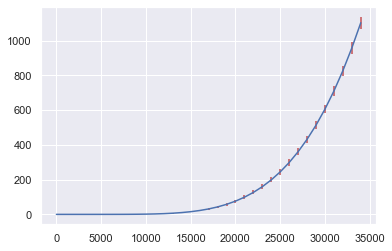

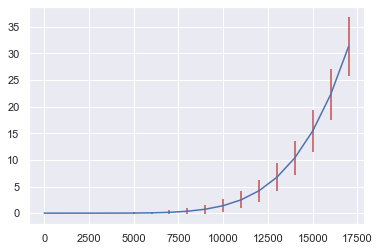

In [5]:
# Visualisation des estimateurs : errorbar
plt.figure()
plt.errorbar(np.arange(0, 2*max_items+1, 1000), np.array(mean_error_count)[0:2*max_items+1:1000], std_error_count[0:2*max_items+1:1000], \
             ecolor = 'r')
plt.show()

plt.figure()
plt.errorbar(np.arange(0, max_items+1, 1000), np.array(mean_error_count)[0:max_items+1:1000], std_error_count[0:max_items+1:1000], \
             ecolor = 'r')
plt.show()

In [6]:
fp_probs[25000] # Se faire une idée des valeurs de probabilités de faux positifs quand on dépasse trop le remplissage max prévu

0.047455965100180436

### 1er cas : p(s) = 1, pour tout s.

Tirage sans remise dans un univers U tel que |U| >> s_max, pour simuler p(s) = 1, pour tout s.

C'est donc un cas à traiter à part (tirage sans remise).

In [83]:
def remplissage_unique(BF, elements, estimateur):

    # Compteurs d'éléments au cours du temps
    count_unique_elements = [0] # Notre compteur pas corrigé
    literature_estimate_count = [0] # Estimateur littérature
    corrected_counter = [0] # Compteur corrigé

    # Nombre d'éléments oubliés (faux positifs)
    error_on_count = [0]
    
    # Erreur des estimateurs
    error_corrected_counter = [0]
    error_literature_estimate = [0]

    # Ajout des éléments dans le filtre, un par un
    i = 0
    while BF.unique_items < max_items:
        element = elements[i]
        BF.add_w_check(element) # Ajout de l'élément (modifie le filtre seulement si check negatif)
        if BF.unique_items == count_unique_elements[-1]: # On ne l'a pas ajouté : erreur (faux positif).
            error_on_count[-1] += 1 # Mon niveau de remplissage n'a pas changé, mais l'erreur a augmenté de 1.
        else: # On l'a ajouté sans faire d'erreur
            count_unique_elements.append(BF.unique_items)
            literature_estimate_count.append(BF.estimate_items)
            error_on_count.append(error_on_count[-1]) # Le niveau de remplissage change, mais l'erreur n'augmente pas
            corrected_counter.append(count_unique_elements[-1] + estimateur[BF.unique_items]) # On ajoute l'estimateur qu'on a fait pour corriger l'erreur de comptage
            error_corrected_counter.append(i+1 - corrected_counter[-1])
            error_literature_estimate.append(i+1 - literature_estimate_count[-1]) # Si on dit que l'estimateur estime le compteur : BF.estimate_items - BF.unique_items
        i += 1
    
    return count_unique_elements, literature_estimate_count, error_on_count, error_corrected_counter, error_literature_estimate, [i]*(BF.unique_items+1)

In [ ]:
n_t = 1000 # Nombre de filtres & flux d'éléments

# Combinaisons possibles dans (filtres différents/identiques, flux d'éléments différents/identiques)
# Combinaison qui semble la plus logique : filtres identiques (copies d'un même filtre), et flux d'éléments différents

tirages_elements = np.array([np.array(random.sample(range(100000), k = 20000)) for t in range(n_t)]) # Elements différents dans chaque flux, uniques (sample)
#tirages_elements = np.array([np.arange(20000) for t in range(n_t)]) # Chaque flux d'éléments est identique

BFs = [copy.deepcopy(BF) for t in range(n_t)] # Filtres identiques : faire varier les éléments
#BFs = [BloomFilter(max_items, 0.01) for t in range(n_t)] # Filtres différents : on peut ne pas faire varier les éléments

In [ ]:
resultats_tirages = []
for t in range(n_t):
    resultats_tirages.append(remplissage_unique(BFs[t], tirages_elements[t, :], mean_error_count))
resultats_tirages = np.array(resultats_tirages)

In [146]:
np.save('Results_1par1_p=1', resultats_tirages)

### 2e cas : p(s) < 1

Différents cas pour l'univers U :

    - |U| >~= s_max : p(s_max) ~= 0, cas peu réaliste.
    - |U| = (1/0.8)*s_max : p(s_max) ~= 0.2
    - |U| = (1/0.6)*s_max : p(s_max) ~= 0.4
    - |U| = (1/0.4)*s_max : p_smax ~= 0.6
    - |U| = (1/0.2)*s_max : p_smax ~= 0.8

In [7]:
# Création de l'univers : on va piocher les éléments aléatoirement donc créer des trajectoires différentes pour le filtre
def creation_univers(s_max, p, n_t):
    
    #tirages_elements = np.array([np.arange(np.round(s_max/(1-p))) for t in range(n_t)]) # Chaque flux d'éléments est identique
    return np.array([np.array(random.sample(range(2*int(np.round(s_max/(1-p)))), k = int(np.round(s_max/(1-p)))))]*n_t)

In [8]:
def remplissage_tirage(BF, elements, estimateur):

    # Compteurs d'éléments au cours du temps
    count_unique_elements = [0] # Notre compteur pas corrigé
    literature_estimate_count = [0] # Estimateur littérature
    corrected_counter = [0] # Compteur corrigé

    # Nombre d'éléments oubliés (faux positifs)
    error_on_count = [0]
    
    # Erreur des estimateurs
    error_corrected_counter = [0]
    error_literature_estimate = [0]

    # Ajout des éléments dans le filtre, un par un, avec tirage uniforme dans l'univers
    elements_seen = []
    i = 0
    while BF.unique_items < max_items:
        element = random.sample(elements, 1)[0]
        BF.add_w_check(element) # Ajout de l'élément (modifie le filtre seulement si check negatif)
        if element not in elements_seen: # Si on ne l'a pas vu (si on l'a déjà vu, il ne sera pas ajouté, pas d'erreur).
            if BF.unique_items == count_unique_elements[-1]: # On ne l'a pas ajouté : erreur (faux positif).
                error_on_count[-1] += 1 # Mon niveau de remplissage n'a pas changé, mais l'erreur a augmenté de 1.
            else: # On l'a ajouté sans faire d'erreur
                count_unique_elements.append(BF.unique_items)
                literature_estimate_count.append(BF.estimate_items)
                error_on_count.append(error_on_count[-1]) # Le niveau de remplissage change, mais l'erreur n'augmente pas
                corrected_counter.append(count_unique_elements[-1] + estimateur[BF.unique_items]) # On ajoute l'estimateur qu'on a fait pour corriger l'erreur de comptage
                error_corrected_counter.append(i+1 - corrected_counter[-1])
                error_literature_estimate.append(i+1 - literature_estimate_count[-1])
            i += 1
            elements_seen.append(element)
    return count_unique_elements, literature_estimate_count, error_on_count, error_corrected_counter, error_literature_estimate

In [9]:
n_t = 1000 # Nombre de filtres & flux d'éléments

# Filtres différents ou identiques : de toute facon les éléments varient (tirage uniforme)
BFs = [copy.deepcopy(BF) for t in range(n_t)] # Filtres identiques : faire varier les éléments
#BFs = [BloomFilter(max_items, 0.01) for t in range(n_t)] # Filtres différents : on peut ne pas faire varier les éléments

In [10]:
# Création des univers
#U = creation_univers(max_items, 0.01, n_t)
#U = creation_univers(max_items, 0.2, n_t)
#U = creation_univers(max_items, 0.4, n_t)
U = creation_univers(max_items, 0.6, n_t)
#U = creation_univers(max_items, 0.8, n_t)

In [11]:
resultats_tirages = []
for t in range(n_t):
    resultats_tirages.append(remplissage_tirage(BFs[t], set(U[t, :]), mean_error_count))
resultats_tirages = np.array(resultats_tirages)

In [12]:
np.save('Results_1par1_p=06', resultats_tirages)

### Analyse des résultats

#### Erreur moyenne

In [13]:
# Les erreurs de comptage
count_errors = np.array(resultats_tirages)[:, 2, :]
mean_count_errors = np.mean(count_errors, axis = 0)
std_count_errors = np.sqrt((1/(n_t-1))*np.sum((count_errors - mean_count_errors)**2, axis = 0))

# Les erreurs des compteurs corrigés
count_corrected_errors = np.array(resultats_tirages)[:, 3, :]
mean_count_corrected_errors = np.mean(count_corrected_errors, axis = 0)
std_count_corrected_errors = np.sqrt((1/(n_t-1))*np.sum((count_corrected_errors - mean_count_corrected_errors)**2, axis = 0))

# Les erreurs de baseline
litterature_errors = np.array(resultats_tirages)[:, 4, :]
mean_literature_estimator_errors = np.mean(litterature_errors, axis = 0)
std_litterature_errors = np.sqrt((1/(n_t-1))*np.sum((litterature_errors - mean_literature_estimator_errors)**2, axis = 0))

In [14]:
print('MBE Proposal', mean_count_corrected_errors[-1])
print('Std MBE Proposal', std_count_corrected_errors[-1])
print('MBE Baseline', mean_literature_estimator_errors[-1])
print('Std MBE Baseline', std_litterature_errors[-1])
print('MAE Proposal', np.mean(np.abs(count_corrected_errors), axis = 0)[-1])
print('Std MAE Proposal', np.std(np.abs(count_corrected_errors), axis = 0)[-1])
print('MAE Baseline', np.mean(np.abs(litterature_errors), axis = 0)[-1])
print('Std MAE Baseline', np.std(np.abs(litterature_errors), axis = 0)[-1])
print('RMSE Proposal', np.sqrt(np.mean(count_corrected_errors**2, axis = 0))[-1])
print('RMSE Baseline', np.sqrt(np.mean(litterature_errors**2, axis = 0))[-1])

MBE Proposal -0.020746359451237366
Std MBE Proposal 5.524036475167315
MBE Baseline -14.391
Std MBE Baseline 30.93795850207762
MAE Proposal 4.3690617378804895
Std MAE Proposal 3.375824927631646
MAE Baseline 27.271
Std MAE Baseline 20.483982986714263
RMSE Proposal 5.521312743490507
RMSE Baseline 34.10719865365668


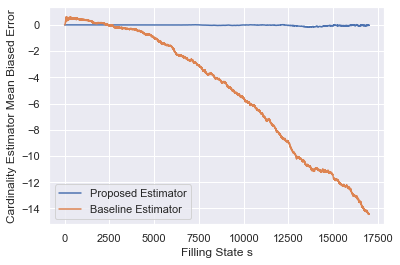

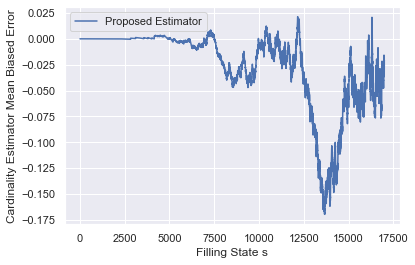

In [15]:
iterations = np.arange(max_items+1)

# Erreur moyenne des compteurs corrigés
plt.figure()
plt.plot(iterations, mean_count_corrected_errors, label = 'Proposed Estimator')
plt.plot(iterations, mean_literature_estimator_errors, label = 'Baseline Estimator')
plt.xlabel('Filling State s')
plt.ylabel('Cardinality Estimator Mean Biased Error')
plt.legend()
plt.show()

# Erreur moyenne des compteurs corrigés : sans la littérature
plt.figure()
plt.plot(iterations, mean_count_corrected_errors, label = 'Proposed Estimator')
plt.xlabel('Filling State s')
plt.ylabel('Cardinality Estimator Mean Biased Error')
plt.legend()
plt.show()

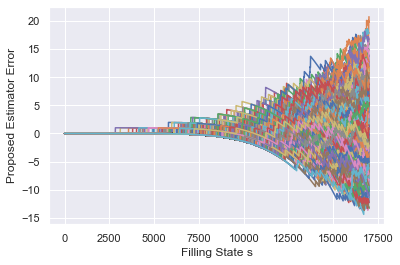

In [16]:
# Tous les tirages
plt.figure()
for t in range(n_t):
     plt.plot(iterations, resultats_tirages[t][3])
plt.xlabel('Filling State s')
plt.ylabel('Proposed Estimator Error')
plt.show()

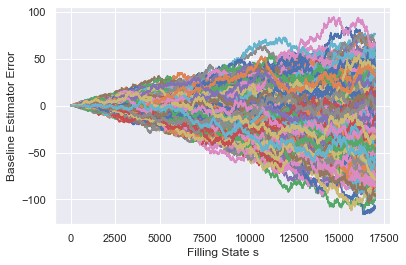

In [17]:
# Tous les tirages
plt.figure()
for t in range(n_t):
     plt.plot(iterations, resultats_tirages[t][4])
plt.xlabel('Filling State s')
plt.ylabel('Baseline Estimator Error')
plt.show()

#### Distribution de l'erreur autour de la moyenne

In [456]:
df_ecart_estimateur = pd.DataFrame()
for t in range(n_t):
    df_ecart_estimateur[f'Tirage_{t}'] = resultats_tirages[t][3]

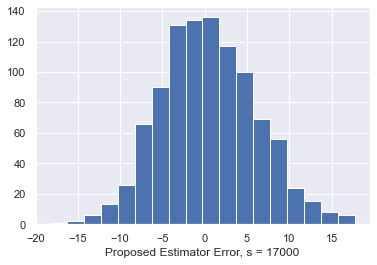

In [457]:
plt.figure()
df_ecart_estimateur.loc[17000].hist(bins = 18)
plt.xlabel('Proposed Estimator Error, s = 17000')
plt.show()

In [458]:
df_ecart_estimateur2 = pd.DataFrame()
for t in range(n_t):
    df_ecart_estimateur2[f'Tirage_{t}'] = resultats_tirages[t][4]

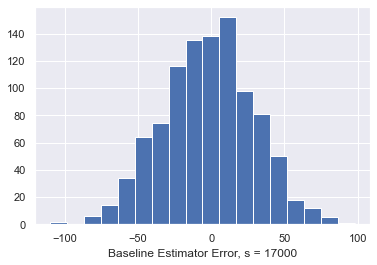

In [459]:
plt.figure()
df_ecart_estimateur2.loc[17000].hist(bins = 18)
plt.xlabel('Baseline Estimator Error, s = 17000')
plt.show()

#### Ecart type estimateurs

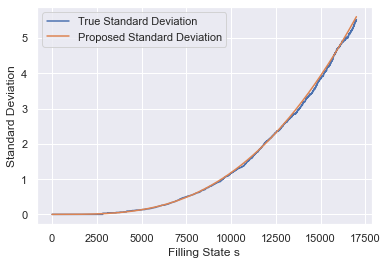

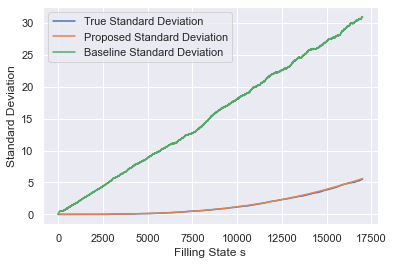

In [18]:
# Ecart type de l'erreur de comptage : on compare l'ecart type de l'estimateur, et l'écart type de l'erreur réelle sur tous les tirages
iterations = np.arange(max_items+1)
plt.figure()
plt.plot(iterations, std_count_errors, label = 'True Standard Deviation') # Ecart type des tirages (estimateur non biaisé de l'écart type)
plt.plot(iterations, np.array(std_error_count)[iterations], label = 'Proposed Standard Deviation') # Ecart type estimé
plt.xlabel('Filling State s')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()

plt.figure()
plt.plot(iterations, std_count_errors, label = 'True Standard Deviation') # Ecart type des tirages (estimateur non biaisé de l'écart type)
plt.plot(iterations, np.array(std_error_count)[iterations], label = 'Proposed Standard Deviation') # Ecart type estimé
plt.plot(iterations, std_litterature_errors, label = 'Baseline Standard Deviation') # Ecart type estimé
plt.xlabel('Filling State s')
plt.ylabel('Standard Deviation')
plt.legend(loc = 'upper left')
plt.savefig('Std_1par1_p=06.png', format = 'png')
plt.show()

#### Violin plots : erreur moyenne et distribution

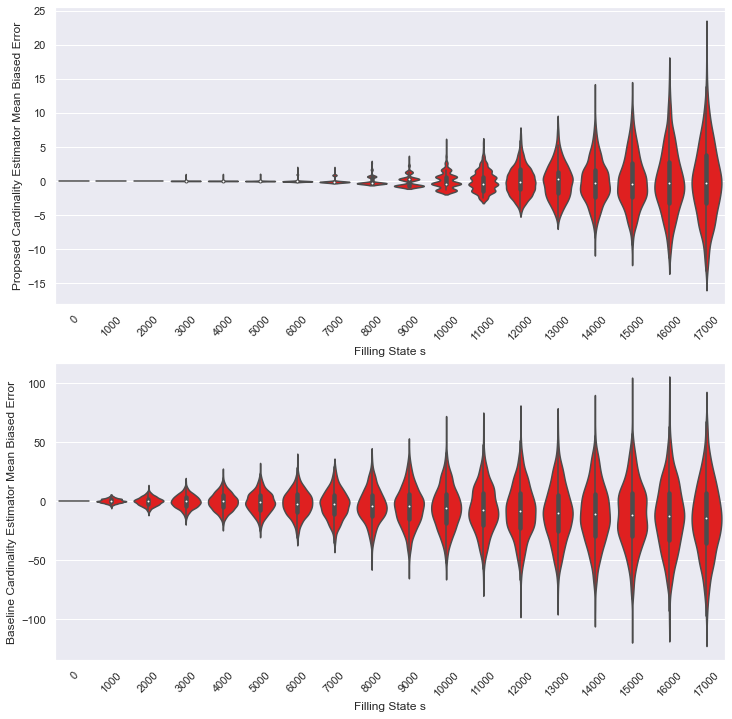

In [19]:
count_corrected_errors_violin = count_corrected_errors[:, ::1000].T.ravel()
litterature_errors_violin = litterature_errors[:, ::1000].T.ravel()
iterations_violin = np.repeat(iterations[::1000], n_t)
data_violin1 = pd.DataFrame({'Filling State s':iterations_violin, 'Proposed Cardinality Estimator Mean Biased Error':count_corrected_errors_violin})
data_violin2 = pd.DataFrame({'Filling State s':iterations_violin, 'Baseline Cardinality Estimator Mean Biased Error':litterature_errors_violin})

plt.figure(figsize = (12, 12))
ax1 = plt.subplot(211)
ax1 = sns.violinplot(x="Filling State s", y="Proposed Cardinality Estimator Mean Biased Error", data = data_violin1, scale = 'width', color = 'red')
plt.xticks(rotation = 45)

ax2 = plt.subplot(212, sharex = ax1)
ax2 = sns.violinplot(x="Filling State s", y="Baseline Cardinality Estimator Mean Biased Error", data = data_violin2, scale = 'width', color = 'red')
plt.xticks(rotation = 45)
plt.savefig('Violin_1par1_p=06.png', format = 'png')
plt.show()

In [20]:
BFs[1].bit_array.count(1)/BFs[0].size # Taux de bits à 1, environ 50% ?

0.4651508177605941